# Оценка результатов А/В-теста для онлайн магазина

## Описание проекта

### Цель исследования

Оценка результатов A/В-теста.

### Техническое задание для А/В-теста

- Название теста: recommender_system_test.
- Группы: А (контрольная), B (новая платёжная воронка).
- Дата запуска: 2020-12-07.
- Дата остановки набора новых пользователей: 2020-12-21.
- Дата остановки: 2021-01-04.
- Аудитория: 15% новых пользователей из региона EU.
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы.
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на - 10%:
    - конверсии в просмотр карточек товаров — событие product_page;
    - просмотры корзины — product_cart;
    - покупки — purchase.

### Описание данных

- *ab_project_marketing_events.csv* — календарь маркетинговых событий на 2020 год:
    - `name` — название маркетингового события;
    - `regions` — регионы, в которых будет проводиться рекламная кампания;
    - `start_dt` — дата начала кампании;
    - `finish_dt` — дата завершения кампании.
- *final_ab_new_users.csv* — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:
    - `user_id` — идентификатор пользователя;
    - `first_date` — дата регистрации;
    - `region` — регион пользователя;
    - `device` — устройство, с которого происходила регистрация.
- *final_ab_events.csv* — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:
    - `user_id` — идентификатор пользователя;
    - `event_dt` — дата и время события;
    - `event_name` — тип события;
    - `details` — дополнительные данные о событии.
- *final_ab_participants.csv* — таблица участников тестов:
    - `user_id` — идентификатор пользователя;
    - `ab_test` — название теста;
    - `group` — группа пользователя.

### Ход выполнения

1. Предобработка данных.
2. Оценка корректности проведения А/В-теста:
   - проверка соответствию требованиям технического задания;
   - проверка совпадения времени проведения теста с маркетинговыми активностями;
   - проверка корректности распределения пользователей по тестовым группам.
3. Исследовательский анализ данных:
   - распределение количества событий на пользователя в выборках;
   - распределение количества событий по дням в выборках;
   - изменение конверсии на разных этапах воронки событий в выборках.
4. Оценка результатов А/В-теста:
   - анализ результатов теста;
   - проверка статистической разницы долей в выборках z-тестом.
5. Общие выводы.

## Предобработка данных

## Загрузка и получение общей информации о данных

In [45]:
#импорт библиотек
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth
pd.set_option('display.float_format', '{:,.2f}'.format)

In [46]:
#загрузка датасетов
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt'])
ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv', parse_dates=['first_date'])
ab_events = pd.read_csv('/datasets/final_ab_events.csv', parse_dates=['event_dt'])
ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [47]:
def information(df): #функция для получения общих сведений о датафрейме
    print('\033[1m' + 'Общая информация:' + '\033[0m')
    df.info()
    print()
    print('\033[1m' + 'Первые 2 строки:' + '\033[0m')
    display(df.head(2))
    print('\033[1m' + 'Количество дубликатов:' + '\033[0m', df.duplicated().sum())
    print()
    print('\033[1m' + 'Количество пропусков:' + '\033[0m')
    display(df.isna().sum())
    print('\033[1m' + 'Доля пропусков:' + '\033[0m')
    print(df.isna().sum() / len(df))

### Календарь маркетинговых событий

In [48]:
information(marketing_events)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes

Первые 2 строки:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16


Количество дубликатов: 0

Количество пропусков:


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Доля пропусков:
name        0.00
regions     0.00
start_dt    0.00
finish_dt   0.00
dtype: float64


In [49]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


В 2020 году состоялось 14 маркетинговых событий, в т.ч. 7 в EU регионе. В датафрейме отсутствуют пропуски и дубликаты.

### Зарегистрировавшиеся пользователи с 7.12.2020 по 21.12.2020

In [50]:
information(ab_new_users)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB

Первые 2 строки:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android


Количество дубликатов: 0

Количество пропусков:


user_id       0
first_date    0
region        0
device        0
dtype: int64

Доля пропусков:
user_id      0.00
first_date   0.00
region       0.00
device       0.00
dtype: float64


В представленом датафрейме информация о 61733 новых пользователях, зарегистрировавшихся с 7.12.2020 по 21.12.2020. Пропуски и дубликаты отсутствуют.

### События новых пользователей с 7.12.2020 по 4.01.2021

In [51]:
information(ab_events)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB

Первые 2 строки:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99


Количество дубликатов: 0

Количество пропусков:


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Доля пропусков:
user_id      0.00
event_dt     0.00
event_name   0.00
details      0.86
dtype: float64


Датафрейм содержит сведения о 440317 событиях. Дубликаты отсутствуют, но в столбце `details` 377577 пропусков, что составляет 86%. Эти пропуски обусловлены тем, что данный столбец содержит дополнительную информацию о событии, например стоимость покупки, поэтому он вполне модет быть и не заполнен, если речь идёт не о покупке, следовательно данные пропуски не являются аномалией или ошибкой. Однако, стоит проверить все ли покупки имеют информацию о стоимости.

In [52]:
ab_events.query('event_name == "purchase"')['details'].isna().sum()

0

Мы убедились, что все покупки имеют информацию о стоимости в столбце `details`

### Таблица участников теста

In [53]:
information(ab_participants)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Первые 2 строки:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test


Количество дубликатов: 0

Количество пропусков:


user_id    0
group      0
ab_test    0
dtype: int64

Доля пропусков:
user_id   0.00
group     0.00
ab_test   0.00
dtype: float64


В таблице участников теста отсутствуют пропуски и дубликаты.

## Промежуточный вывод

Из представленных датафреймов только в *ab_events* в столбце `details` наблюдаются пропуски (86%), но они не носят аномального характера. Столбцы содержащие даты были приведены к необходимому формату (datetime) при загрузке файлов.

# Оценка корректности проведения A/В-теста

## Проверка соответствия требованиям технического задания

### Название теста: recommender_system_test

In [54]:
recommender_system_test = ab_participants.query('ab_test == "recommender_system_test"')
#сохранение данных о тесте в отдельную переменную
recommender_system_test

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


Тест с соответствующим названием есть, в нём приняли участие 6701 пользователь. 

### Группы: А (контрольная), B (новая платёжная воронка);\

In [55]:
recommender_system_test.groupby('group').agg({'user_id' : 'nunique'})

,user_id
group,
A,3824
B,2877


Участники теста разделены на две группы, разделение неравномерное в группе А почти на тысячу пользователей больше.

### Дата запуска теста: 2020-12-07

In [56]:
recommender_system_test = recommender_system_test.merge(ab_events, on='user_id', how='left')
#добавление данных о действиях пользователей

In [57]:
print('Дата начала теста:', recommender_system_test['event_dt'].min())

Дата начала теста: 2020-12-07 00:05:57


Дата начала теста соответствует заявленной в техзадании. 

### Дата остановки набора новых пользователей: 2020-12-21

In [58]:
recommender_system_test = recommender_system_test.merge(ab_new_users, on='user_id', how='left')
#добавление данных о регистрации пользователей

In [59]:
print('Дата остановки набора новых пользователей', recommender_system_test['first_date'].max())

Дата остановки набора новых пользователей 2020-12-21 00:00:00


Дата остановки набора новых пользователей соответствует техническому заданию.

### Дата остановки теста: 2021-01-04

In [60]:
print('Дата остановки теста:', recommender_system_test['event_dt'].max())

Дата остановки теста: 2020-12-30 12:42:57


Последнее событие датируется 30.12.2020г., значит тест был остановлен раньше даты заявленной в техническом задании.

### Аудитория: 15% новых пользователей из региона EU

In [61]:
recommender_system_test.groupby('region').agg({'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False) 
#количество участников теста по регионам

,user_id
region,
EU,6351
N.America,223
APAC,72
CIS,55


Большинство участников теста относятся к Европейскому региону (6351), и в общей сложности 350 участников представляют ещё три региона Северная Америка (223), Азиатско-Тихоокеанский регион (72) и СНГ (55).

In [62]:
print('Доля новых пользователей из региона EU, среди участников теста: {:.1%}'.format(recommender_system_test.query(
    'region == "EU"')['user_id'].nunique() / ab_new_users.query('region == "EU"')['user_id'].nunique()))
#количество пользователей по регионам

Доля новых пользователей из региона EU, среди участников теста: 13.7%


Доля участников теста из Европейского региона составляет 13,7% от новых пользователей из данного региона, в то время как по техническому заданию их должно быть 15%.

Также в данном пункте технического задания стоило бы уточнить допускается ли участие в тесте пользователей из других регионов.

### Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы

К формулировке назначения теста у меня вопросов не возникло.

### Ожидаемое количество участников теста: 6000

In [63]:
recommender_system_test['user_id'].nunique()

6701

В тесте приняли участие 6701 пользователь. Если обратиться к пункту технического задания в котором речь идёт о присутствии 15% новых пользователей Европейского региона среди участников теста, то можно обнаружить некоторое несоответствие требований данного пункта с требованиями к ожидаемому количеству участников. В тесте приняли участие 6351 пользователь из Европейского региона и при этом необходимые 15% от новых пользователей из данного региона не были достигнуты, т.е. ожидаемого количества участников в 6000, по умолчанию недостаточно чтобы соответствовать, названному выше, критерию.

### Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на - 10%: конверсии в просмотр карточек товаров — событие product_page; просмотры корзины — product_cart; покупки — purchase.

Заказчик ожидает увеличение метрик за 14 дней с момента регистрации пользователя, но ранее мы выяснили, что тест был остановлен раньше срока указанного в техническом задании, а значит не все пользователи могли находится в тесте заявленные в ТЗ 14 дней. Тест остановили 30.12.2020, т.е. пользователи зарегистрировавшиеся после 16.12.2020 провели в тесте меньше 14 дней.

In [64]:
recommender_system_test.query('first_date > @dt.date(2020, 12, 16)')['user_id'].nunique()
#количество пользователей, зарегистрировавшихся после 16.12.2020

2387

Пользователей, находившихся в тесте менее 14 дней очень много - около 1/3 от всех участников, посмотрим как они распределены внутри групп. 

In [65]:
print('Доля участников зарегистрированных после 16.20.2020 в группе А: {:.1%}'.format(recommender_system_test.query(
    'first_date > @dt.date(2020, 12, 16) and group == "A"')['user_id'].nunique() / recommender_system_test.query(
   'group == "A"')['user_id'].nunique())
     )
print('Доля участников зарегистрированных после 16.20.2020 в группе B: {:.1%}'.format(recommender_system_test.query(
    'first_date > @dt.date(2020, 12, 16) and group == "B"')['user_id'].nunique() / recommender_system_test.query(
   'group == "B"')['user_id'].nunique())
     )

Доля участников зарегистрированных после 16.20.2020 в группе А: 35.6%
Доля участников зарегистрированных после 16.20.2020 в группе B: 35.6%


Несмотря на то, что пользователей, находившихся в тесте менее 14 дней, значительное количество, между тестовыми группами они распределены равномерно - по 35,6% в каждой группе.

Также учитывая требование ТЗ необходимо отфильтровать события которые были совершены польщователями позднее 14 дней с момента регистрации.

In [66]:
#подсчёт для кажого события количества дней прошедших с момента регистрации
recommender_system_test['event_timedelta'] = (recommender_system_test['event_dt'] - recommender_system_test['first_date']
                                             ).apply(lambda x: x.days)

In [67]:
#удаление событий произошедших позднее 14 дней после регистрации
recommender_system_test_ft = recommender_system_test.query('event_timedelta <= 14')

In [68]:
#проверка количества пользователей в тесте после фильтрации
recommender_system_test_ft['user_id'].nunique()

3675

In [69]:
#количество событий совершенных позднее 14 дней после регистрации
len(recommender_system_test.query('event_timedelta > 14'))

628

Количество пользователей-участников теста резко сократилось после удаления событий произошедших позднее 14 дней после регистрации пользователя, хотя количество таких событий относительно небольшое. Возможно у нас изначально есть информация о событиях не от всех пользователей.

In [70]:
#количество пользователей совершивших хотя бы одно событие
recommender_system_test[~(recommender_system_test['event_name'].isna())]['user_id'].nunique()

3675

Около половины пользователей вообще не совершали никаких действий, поэтому количество участников теста совершавших действия, после фильтрации не изменилось. Тот факт, что из необходимых по ТЗ 6000 участников только чуть более половины совершали действия сильно ограничивает мощность нашего теста.

## Проверка совпадения времени проведения теста с маркетинговыми активностями

In [71]:
marketing_events.query('start_dt >= @dt.date(2020, 12, 7) and start_dt <= @dt.date(2020, 12, 30)')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Последний день проведения теста совпадает с началом Ногодней лотереи подарков в регионе СНГ. Так как в тесте участвует небольшое количество пользователей из СНГ и совпадает всего один день, то данным фактом можно принебречь. 

Также проведение теста частично совпадает по времени с Новогодней и Рождественской промоакциями для пользователей Европейского и Северо-Американского региона. Наложение дат захватывает только последние 5 дней тест, тем не менее это может сказаться на его результатах, например, за счёт резкого увеличения количества покупок в период проведения промоакции, на что стоит обратить внимание при изучении распределения событий по дням теста.

## Проверка корректности распределения пользователей по тестовым группам

In [72]:
len(recommender_system_test.groupby('user_id').agg({'group': 'nunique'}).reset_index().query('group > 1'))

0

Пользователи, которые одновременно входили бы в обе тестовых группы, отсутствуют. Проверим есть ли пользователи которые одновременно участвуют в конкурирующем тесте.

In [73]:
len(ab_participants.groupby('user_id').agg({'ab_test': 'nunique'}).reset_index().query('ab_test > 1'))

1602

В конкурирующем тесте участвуют 1602 пользователя. Стоит посмотреть, как пользователи участвующие в двух тестах распределены по группам.

In [74]:
#получение id пользователей, участвующих в обоих тестах
double_test = ab_participants.groupby('user_id').agg({'ab_test': 'nunique'}).reset_index().query('ab_test > 1')['user_id']

#распределение по группам для конкурирующего теста
ab_participants.query('user_id in @double_test and ab_test != "recommender_system_test"').groupby('group').agg(
    {'user_id' : 'nunique'})

,user_id
group,
A,819
B,783


Если бы все пользователи, участвующие в двух тестах,  в конкурирующем тесте находились бы только в группе А, то можно было бы не беспокоится, т.к. это означало бы, что на них не оказывалось воздействие в рамках конкурирующего теста, но мы выяснили что это не так и пользователи были распределены по обеим группам конкурирующего теста.

Теперь оценим распределение пользователей группы В, конкурирующего теста среди групп анализируемого теста (распределение пользователей из группы А оценивать не будем по выше названной причине). 

In [75]:
#получение id пользователей, участвующих в обоих тестах и в группе В конкурирующего теста
double_test_B = ab_participants.query('user_id in @double_test and ab_test != "recommender_system_test" and group =="B"'
                                     )['user_id']

print('Доля участников группы В конкурирующего теста в группе А анализируемого: {:.1%}'.format(recommender_system_test.query(
    'user_id in @double_test_B and group == "A"')['user_id'].nunique() / recommender_system_test.query(
   'group == "A"')['user_id'].nunique())
     )
print('Доля участников группы В конкурирующего теста в группе В анализируемого: {:.1%}'.format(recommender_system_test.query(
    'user_id in @double_test_B and group == "B"')['user_id'].nunique() / recommender_system_test.query(
   'group == "B"')['user_id'].nunique())
     )

Доля участников группы В конкурирующего теста в группе А анализируемого: 11.5%
Доля участников группы В конкурирующего теста в группе В анализируемого: 12.0%


Участники группы В конкурирующего теста распределены относительно равномерно в группах анализируемого теста их доли 11,5% и 12,0% в группе А и группе В соответственно.

Также ранее мы выяснили, что пользователи были неравномерно распределены на контрольную (А) и тестовую группы (В), и в группе А пользователей почти на тысячу больше.

In [76]:
recommender_system_test.groupby('group').agg({'user_id' : 'nunique'})

,user_id
group,
A,3824
B,2877


Это может быть связано с тем, что инструмент по распределению трафика настроен неккоректно или работает неправильно.

## Промежуточный вывод

В ходе оценки корректности проведения теста выявлено:
1. Пользователи неравномерно распределены по группам анализируемого теста, в контрольной группе почти на тысячу больше участников, чем в опытной.
2. Тест остановлен на 5 дней раньше срока указанного в ТЗ, что привело к сокращению срока нахождения в тесте у 1/3 пользователей, распределение таких пользователей внутри тестовых групп равномерное (по 36,5%).
3. Наблюдается расхождение с ТЗ в части аудитории теста, так согласно ТЗ аудиторию теста должны составлять не менее 15% новых пользователей Европейского региона, в реальности этот показатель составляет 13,7%, но также стоит отметить, что при заявленной мощности теста в 6000 участников, уровень в 15% не достижим.
4. Последние 5 дней теста совпадают с началом Рождественской и Новогодней промо-акции в Европейском регионе, что следует учесть при дальнейшем анализе.
5. 1602 пользователя учасвуют в конкурирующем тесте, в т.ч. 783 пользователя находятся в опытной группе (В). Пользователи, находящиеся в группе "В" конкурирующего теста, относительно равномерно распределены по группам анализируемого теста (А - 11,5%, В - 12,0%).
6. Из 6701 участника теста, какие-либо события зарегистрированы только у 3675 пользователей.

# Исследовательский анализ данных

## Распределение количества событий на пользователя в выборках

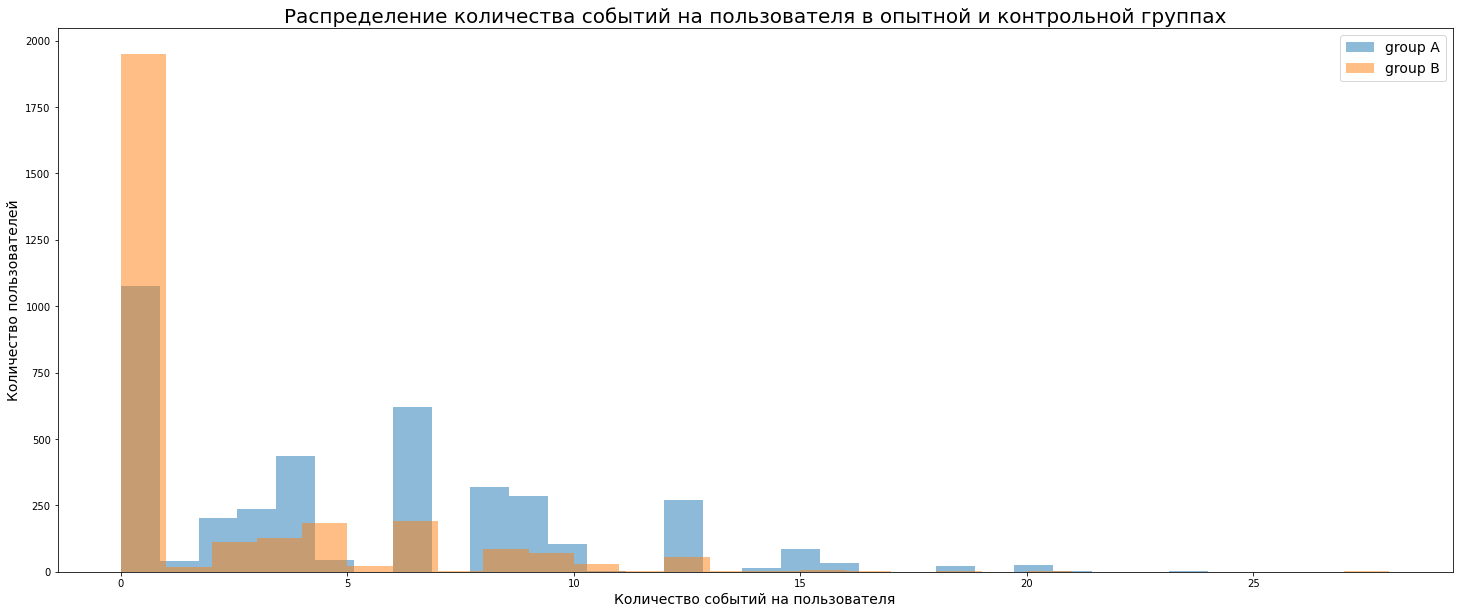

In [77]:
plt.figure(figsize=(25, 10))
plt.title('Распределение количества событий на пользователя в опытной и контрольной группах', fontsize=20)
plt.ylabel('Количество пользователей', fontsize=14)
plt.xlabel('Количество событий на пользователя', fontsize=14)
plt.hist(recommender_system_test.query('group == "A"').groupby('user_id')['event_name'].count(), bins=28, alpha=0.5, 
         label='group A')
plt.hist(recommender_system_test.query('group == "B"').groupby('user_id')['event_name'].count(), bins=28, alpha=0.5, 
         label='group B')
plt.legend(fontsize=14)
plt.show()

In [78]:
#характерные значения анализируемого показателя в группе А
recommender_system_test.query('group == "A"').groupby('user_id')['event_name'].count().describe()

count   3,824.00
mean        5.05
std         4.55
min         0.00
25%         0.00
50%         4.00
75%         8.00
max        24.00
Name: event_name, dtype: float64

In [79]:
#характерные значения анализируемого показателя в группе В
recommender_system_test.query('group == "B"').groupby('user_id')['event_name'].count().describe()

count   2,877.00
mean        1.87
std         3.36
min         0.00
25%         0.00
50%         0.00
75%         3.00
max        28.00
Name: event_name, dtype: float64

Глядя на гистограммы можно заключить, что с одной стороны распределение показателя в тестовых группах имеет сходный характер, но при этом в группе В, гораздо в большей степени выражено преобладание пользователей не совершивших ни одного события, таких пользователей в группе В, как минимум половина. Количество событий на пользователя ваоьируется от 0 до 24 в группе А и от 0 до 28 в группе В; среднее количество событий на пользователя в группе А составляет 5,05, при стандартном отклонении 4,55, в то время как в группе В лишь 1,87, при стандартном отклонении 3,36.

## Распределение количества событий по дням в выборках

In [80]:
#извлечение данных о дате события в отдельный столбец
recommender_system_test['event_date'] = recommender_system_test['event_dt'].dt.date 

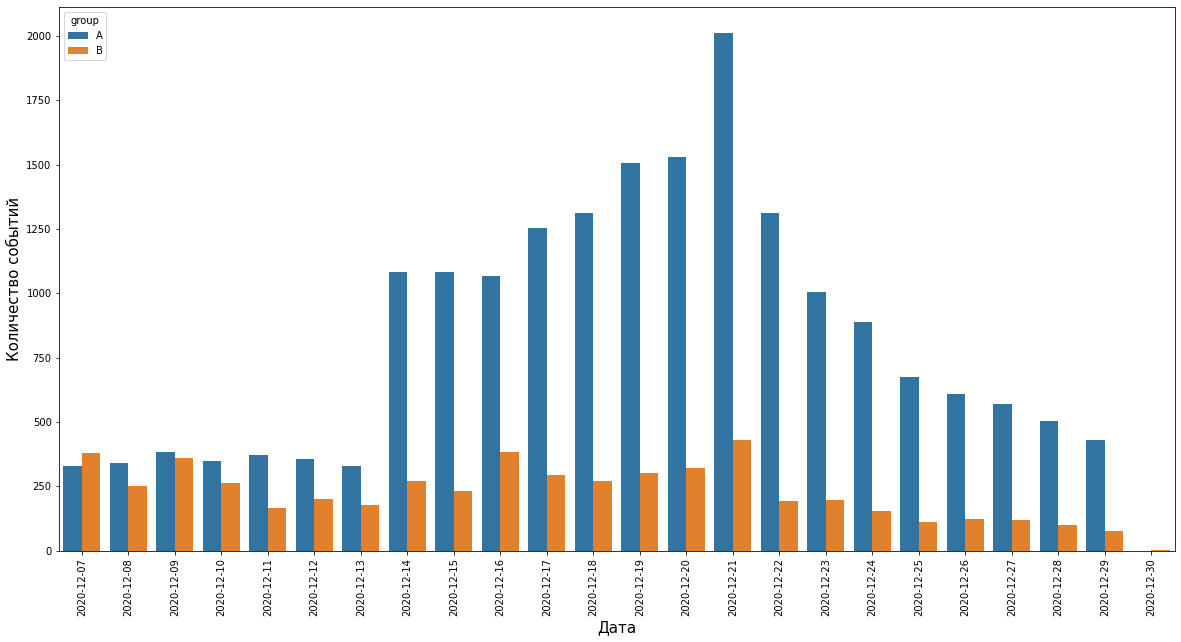

In [81]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x='event_date', y='event_name', hue='group', data=recommender_system_test.groupby(
    ['event_date' , 'group']).agg({'event_name' : 'count'}).reset_index())
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Количество событий', fontsize=15)
plt.xticks(rotation=90)
plt.show()

В группе "А" количество событий резко возрастает через неделю после начала теста (14.12), далее начиная с 17.12 количество событий в день нарастает, и к 14-му дню теста (21.12) достигает своего максимума, после чего постоянно снижается. 

В группе "В", на протяжении первой недели количество событий сопоставимо с группой "А",но в момент когда в группе "А" наблюдается значительный рост количества событий, в группе "В" аналогичного значительного роста не наблюдается, хотя своего максимума количество событий в день, также достигает к 14 дню теста (21.12), после чего снижается примерно вдвое и продолжает падать вплоть до конца теста.

Как мы помним, последние 5 дней теста совпали с проведением Новогодней промоакции, тем не менее, мы не наблюдаем резкого увеличения количества событий в последние 5 дней теста. Но стоит отдельно проверить событие 'purchase' (покупка), поскольку в период промоакции может наблюдаться изолированный рост частоты именно этого события.

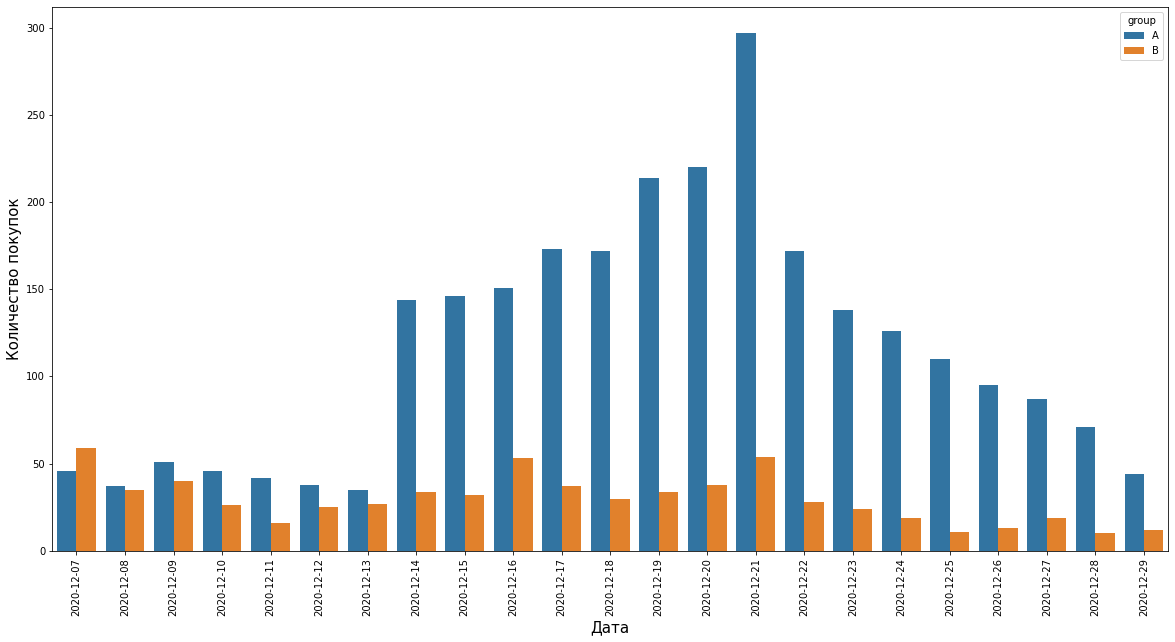

In [82]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x='event_date', y='event_name', hue='group', data=recommender_system_test.query(
    'event_name == "purchase"').groupby(['event_date' , 'group']).agg({'event_name' : 'count'}).reset_index())
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Количество покупок', fontsize=15)
plt.xticks(rotation=90)
plt.show()

Как видно динамика количество покупок, в целом, повторяет динамика количества всей совокупности событий. По всей видимости Новогодняя акция не оказала выраженного влияния на участников теста.

## Изменение конверсии на разных этапах воронки событий в выборках

In [83]:
recommender_system_test_ft.groupby(['event_name', 'group']).agg({'event_dt' : 'count'})
#количество событий по видам и тестовым группам

event_dt
event_name   group          
login        A          8400
             B          2493
product_cart A          2519
             B           659
product_page A          5415
             B          1331
purchase     A          2613
             B           640

Чаще всего в обоих тестовых группах происходит регистрация пользователей ('login'), далее по частоте следует просмотр карточки товара ('product_page'). Третьим по частоте событием в группе "А" является покупка ('purchase') и самым редким событием - просмотр корзины с товаром ('product_cart'), а в группе "В" наоборот. Логичной последовательностью событий представляется следующая: регистрация - просмотр карточки товара - просмотр корзины с товаром - покупка.

Построим воронку событий для каждой тестовой группы.

In [84]:
#построение воронки событий для тестовой группы А
fig = go.Figure(go.Funnel(y=recommender_system_test_ft.query('group == "A"').groupby('event_name').agg(
    {'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False).index, x=recommender_system_test_ft.query(
    'group == "A"').groupby('event_name').agg({'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False)[
    'user_id'])) 
fig.show()

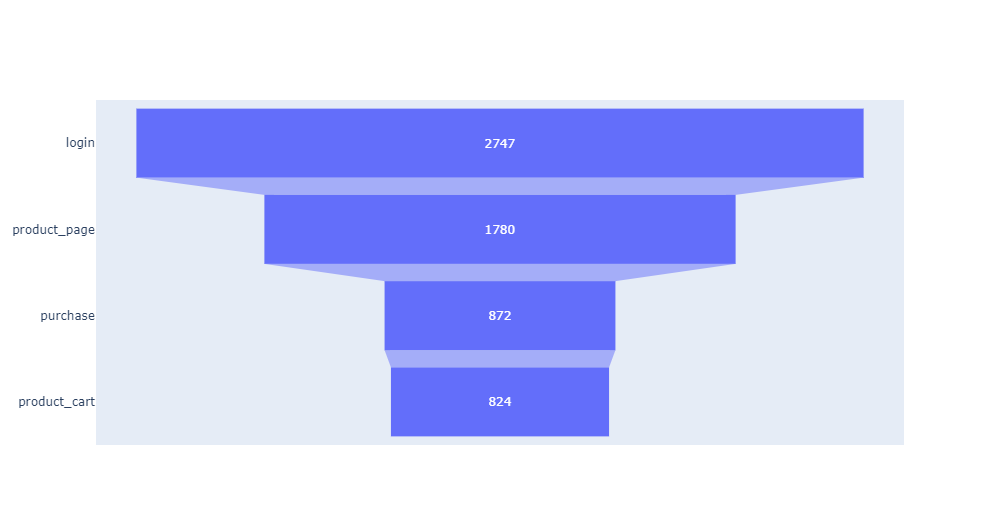

В воронке количество пользователей совершивших покупку превышает количество пользователей просмотревших корзину с товаром. Это значит, что просмотр корзины является необязательным этапом и совершить покупку можно сразу со страницы с товаром. В этом случае лучше ориентироваться не на конверсию от этапа к этапу, а на конверсию от первого этапа, иначе мы получим конверсию более 100% из просмотра корзины в покупку. Но этапа врронки всё равно необходимо выстроить в логической последовательности.

In [85]:
new_index = ['login', 'product_page', 'product_cart', 'purchase'] #корректная последовательность индексов

fig = go.Figure(go.Funnel(y=recommender_system_test_ft.query('group == "A"').groupby('event_name').agg(
    {'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False).reindex(new_index).index, 
                          x=recommender_system_test_ft.query('group == "A"').groupby('event_name').agg(
                              {'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False).reindex(
                              new_index)['user_id'])) 
fig.show()

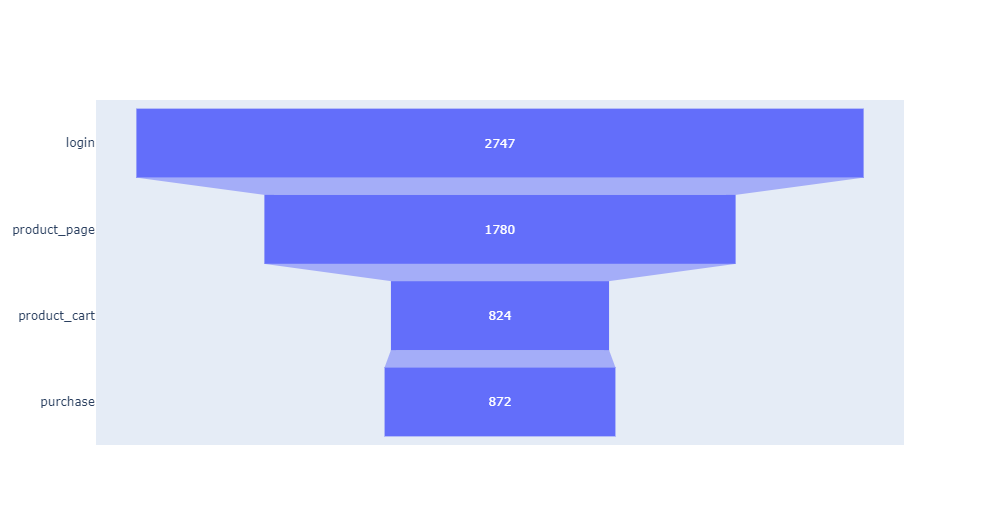

В группе "А" регистрацию прошли 2747 пользователей, 1780 пользователей просмотрели карточку товара, конверсия на этом этапе составила 64,8%; 824 пользователя просмотрели корзину с товаром, конверсия с предыдущего этапа составила 46,3%, а конверсия из регистрации составила 30%; и 872 пользователя совершили покупку, конверсия от первого этапа - 31,7%.

In [86]:
fig = go.Figure(go.Funnel(y=recommender_system_test_ft.query('group == "B"').groupby('event_name').agg(
    {'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False).reindex(new_index).index, 
                          x=recommender_system_test_ft.query('group == "B"').groupby('event_name').agg(
                              {'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False).reindex(
                              new_index)['user_id'])) 
fig.show()

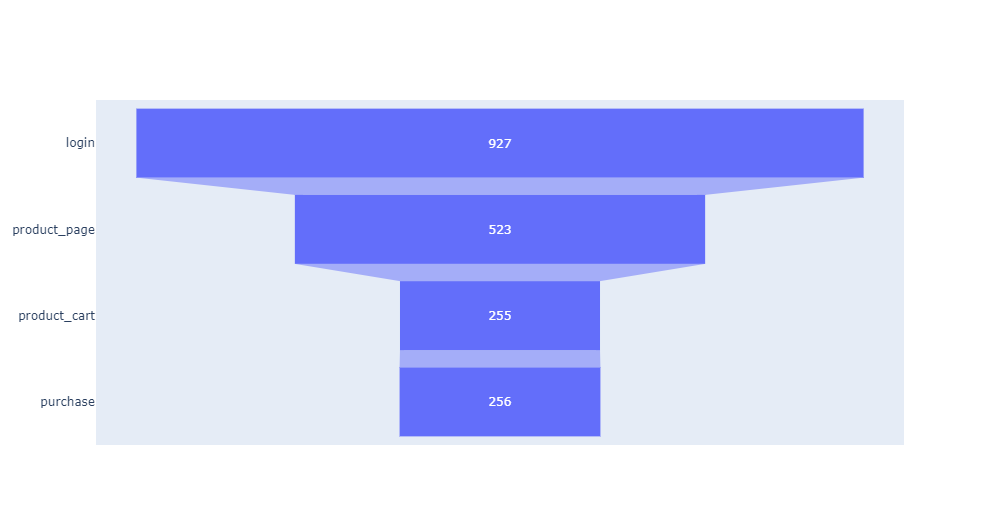

В группе "В" регистрацию прошли 928 пользователей, 523 из них или 56,4% просмотрели страницу товара; 225 пользователей просмотрели корзину, что составило 48,8% от просмотревших страницу товара и 27,5% от зарегистрированных; покупку совершили 256 пользователей, конверсия зарегистрированных пользователей в покупку составила 27,6%.

## Промежуточный вывод

1. Прежде чем приступать к тестированию стоит учесть выявленные ранее особенности:
- тестовые группы сформированы неравномерно: начиная со второй недели начинают резко преобладать количество, совершаемых пользователями, событий в группе "А", что может свидетельствовать о сбое в настройках разделения трафика на группы.
- тест остановлен раньше необходимого срока и значительное количетсво пользователей находилось в тесте меньше, заложенных в ТЗ, 14 дней, но такие пользователи распределены в тестовых группах равномерно;
- Количество пользователей из Европейского региона в тесте составляет менее 15% от всех новых пользователей из региона EU, что не соответствует ТЗ;
- последние 5 дней теста совпадают с началом Новогодней промоакции, хотя это и не привело к резкому увеличению количества событий в соответствующие дни проведения теста;
- часть пользователей, участвующих в тесте, паралельно участвовали в конкурирующим тесте, при чём находились в опытной группе, эти пользователи распределены равномерно по группам анализируемого теста, но тем не менее, это могло оказать влияние на результаты анализируемого теста.
Выше обозначенное затрудняет интерпретацию и экстраполяцию результатов теста, данные моменты стоит учесть при планировании будущих тестов.

По результатам исследовательского анализа выявлено:
1. Распределение количества событий на пользователя в тестовых группах имеет сходный характер, однако, в группе "В" в большей степени преобладают пользователи не совершившие ни одного действия, и среднее количество событий на пользователя ниже, чем в группе "А": 1,87 и 5,05 при стандартных отклонениях 3,36 и 4,55 соответственно.
2. В первую неделю теста количество событий в день в обоих тестовых группах сопоставимо, но со второй недели теста количество событий в группе "А" начинает резко преобладать, своего пика количество событий в обоих тестовых группах достигает по окончании второй тестовой недели (21.12), после чего снижается до окончания теста.
3. Последовательность событий от регистрации до покупки выглядит следующим образом: регистрация - просмотр карточки товара - просмотр корзины с товаром - покупка, причём просмотр корзины является необязательныь этапом, и покупка возможна минуя его.
4. Конверсию из регистрации в каждый из этапов в группе "В" несколько уступает таковой в гуппе "А", конверсия из просомтра сттраницы товара в просмотр корзины, напротив несколько выше в группе "В".

# Оценка результатов А/В-теста

## Анализ результатов теста

Ожидаемом эффекта вмешательства было увеличение конверсии в просмотр карточек товара, просмотр корзины и покупки не менее чем на 10%. По результату конверсия в группе "В" почти на всех этапах уменьшилась относительно группы "А":
- регистрация - просмотр карточки товара - на 8,4%;
- регистрация - просмотр корзины с товаром - на 2,5%;
- регистрация - покупка - на 4,1%.

Рост конверсии отмечается только на шаге просмотр страницы товара - просмотр корзины - на 2,5%.

Теперь оценим на сколько разница в конверсии между группами "А" и "В" статистически значима для чего используем z-тест.

## Проверка статистической разницы долей в выборках z-тестом

Выдвинем нулевую и альтернативную гипотезы.

Нулевая гипотеза: "Конверсии на разных этапах в группе "А" и группе "В" не различаются"
Альтернативная гипотеза: "Конверсии на разных этапах в группе "А" и группе "В" различаются"

В качестве критического уровня статистической значимости различий возьмём 5%, так как мы будем проводить несколько сравнений (а именно четыре) на одной и той же выборке, следует сделать поправку на множественные сравнения, для этой цели воспользуемся поправкой Бонферрони. Сравнение необходимо выполнить несколько раз, поэтому для удобства напишем соответствующкю функцию.

In [87]:
def z_test(x1, n1, x2, n2):
    
    bonferroni_alpha = .05/4 #критический уровень статистической значимости c поправкой Бонферрони

    event = np.array([x1, x2]) #количество совершивших событие пользователей
    group = np.array([n1, n2]) #количество пользователей в группах
        
    p1 = event[0]/group[0] #доля пользователей, совершивших событие в первой группе
    p2 = event[1]/group[1]  #доля пользователей, совершивших событие во второй группе

    p_combined = (event[0] + event[1]) / (group[0] + group[1]) #доля пользователей, совершивших события в объединённой группе

    difference = p1 - p2 #разница долей в группах
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / event[0] + 1 / event[1])) #расчет z-статистики

    distr = st.norm(0, 1) #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Конверсия в группе А составляет: {:.1%}'.format(p1))
    print('Конверсия в группе B составляет: {:.1%}'.format(p2))
    
    print('p-значение: ', p_value)
    
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными') 

### Конверсия регистрация - просмотр страницы с товаром

In [88]:
z_test(recommender_system_test_ft.query('group == "A" and event_name == "product_page"')['user_id'].nunique(),
       recommender_system_test_ft.query('group == "A" and event_name == "login"')['user_id'].nunique(),
      recommender_system_test_ft.query('group == "B" and event_name == "product_page"')['user_id'].nunique(),
       recommender_system_test_ft.query('group == "B" and event_name == "login"')['user_id'].nunique())

Конверсия в группе А составляет: 64.8%
Конверсия в группе B составляет: 56.4%
p-значение:  0.0004951285914125414
Отвергаем нулевую гипотезу: между конверсиями есть значимая разница


Конверсия из регистрации в просмотр страницы с товаром в группе "B" статистически значимо ниже, чем конверсия в группе "А".

### Конверсия регистрация - просмотр корзины с товаром

In [89]:
z_test(recommender_system_test_ft.query('group == "A" and event_name == "product_cart"')['user_id'].nunique(),
       recommender_system_test_ft.query('group == "A" and event_name == "login"')['user_id'].nunique(),
      recommender_system_test_ft.query('group == "B" and event_name == "product_cart"')['user_id'].nunique(),
       recommender_system_test_ft.query('group == "B" and event_name == "login"')['user_id'].nunique())

Конверсия в группе А составляет: 30.0%
Конверсия в группе B составляет: 27.5%
p-значение:  0.44582426799055797
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


Конверсия из регистрации в просмотр корзины с товаром в группе "B" и "А" статистически не различается.

### Конверсия регистрация - покупка

In [90]:
z_test(recommender_system_test_ft.query('group == "A" and event_name == "purchase"')['user_id'].nunique(),
       recommender_system_test_ft.query('group == "A" and event_name == "login"')['user_id'].nunique(),
      recommender_system_test_ft.query('group == "B" and event_name == "purchase"')['user_id'].nunique(),
       recommender_system_test_ft.query('group == "B" and event_name == "login"')['user_id'].nunique())

Конверсия в группе А составляет: 31.7%
Конверсия в группе B составляет: 27.6%
p-значение:  0.20806462102776235
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


Конверсия из регистрации в покупку в группе "B" и "А" статистически не различается.

### Конверсия просмотр страницы с товаром - просмотр корзины с товаром

In [91]:
z_test(recommender_system_test_ft.query('group == "A" and event_name == "product_cart"')['user_id'].nunique(),
       recommender_system_test_ft.query('group == "A" and event_name == "product_page"')['user_id'].nunique(),
      recommender_system_test_ft.query('group == "B" and event_name == "product_cart"')['user_id'].nunique(),
       recommender_system_test_ft.query('group == "B" and event_name == "product_page"')['user_id'].nunique())

Конверсия в группе А составляет: 46.3%
Конверсия в группе B составляет: 48.8%
p-значение:  0.4906041880307246
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


Конверсия из просмотра страницы товара в просмотр корзины с товаром в группе "B" и "А" статистически не различается.

### Промежуточный вывод

По результатам проверки статистической разницы в тестовых группах выявлено, что конверсия из регистрации в просмотр страницы с товаром в группе "В" значимо ниже, чем в группе "А"; по остальным конверсиям статистической разницы между тестовыми группами не выявлено.

Таким образом, ожилаемый эффект от тестируемого воздействия не был достигнут.

# Общий вывод

1. Оценка корректности теста и соответствия ТЗ:
- пользователи неравномерно распределены по группам анализируемого теста, в контрольной группе почти на тысячу больше участников, чем в опытной.
- тест остановлен на 5 дней раньше срока указанного в ТЗ, что привело к сокращению срока нахождения в тесте у 1/3 пользователей, распределение таких пользователей внутри тестовых групп равномерное (по 36,5%).
- наблюдается расхождение с ТЗ в части аудитории теста, так согласно ТЗ аудиторию теста должны составлять не менее 15% новых пользователей Европейского региона, в реальности этот показатель составляет 13,7%, но также стоит отметить, что при заявленной мощности теста в 6000 участников, уровень в 15% не достижим.
- последние 5 дней теста совпадают с началом Рождественской и Новогодней промо-акции в Европейском регионе.
- 1602 пользователя учасвуют в конкурирующем тесте, в т.ч. 783 пользователя находятся в опытной группе (В). Пользователи, находящиеся в группе "В" конкурирующего теста, относительно равномерно распределены по группам анализируемого теста (А - 11,5%, В - 12,0%);
- из 6701 участника теста, какие-либо действия совершались только 3675 пользователями, что ограничивает реальную мощность теста.
2. Исследовательский анализ данных:
- распределение количества событий на пользователя в тестовых группах имеет сходный характер, однако, в группе "В" в большей степени преобладают пользователи не совершившие ни одного действия, и среднее количество событий на пользователя ниже, чем в группе "А": 1,87 и 5,05 при стандартных отклонениях 3,36 и 4,55 соответственно;
- в первую неделю теста количество событий в день в обоих тестовых группах сопоставимо, но со второй недели теста количество событий в группе "А" начинает резко преобладать, своего пика количество событий в обоих тестовых группах достигает по окончании второй тестовой недели (21.12), после чего снижается до окончания теста;
- последовательность событий от регистрации до покупки: регистрация - просмотр карточки товара - просмотр корзины с товаром - покупка, просмотр корзины является необязательным этапом и покупка возможна минуя его.
3. Оценка результатов А/В-теста:
- в результате тестируемого воздействия в группе "В" не наблюдалось ожидаемого эффекта в виде увеличения конверсии на разных этапах продуктовой воронки не менее чем на 10%, в большинстве случаев наблюдалось снижение конверсии в группе "В" по сравнению с группой "А":
    - регистрация - просмотр карточки товара - снижение на 8,4%;
    - регистрация - просмотр корзины с товаром - снижение на 2,5%;
    - регистрация - покупка - снижение на 4,1%;
    - просмотр страницы товара - просмотр корзины - рост на 2,5%.
- в ходе статистической проверки разницы конверсий в тестовых группах z-тестом, выявлена статистически достоверное снижение конверсии регистрация - просмотр карточки товара.
4. Учитывая проблемы, выявленные на этапе оценки корректности теста и его соответствия ТЗ, следует осторожно подходить к интерпритации результатов проведенного теста. Возможно, следует повторить тест с учётом выявленных проблем и недостатков. 